In [1]:
from shiftNMF_frozen import ShiftNMF
from nnls_l1 import nnls
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from helpers.generators import *
from helpers.data import X_ART, X_ART_NOISY, TAU_ART, W_ART, H_ART
from Hardmodel_single_peaks import Single_Model
from Hardmodel import Hard_Model
import scipy
from scipy.signal import find_peaks
import itertools
from helpers.fit_functions import *

# Data

In [2]:
# Create a gridspec object with 2 rows and 3 columns
from helpers.plot import *
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 1])

fig = plt.figure(figsize=(10, 6))
N, M = X_ART.shape

# Plot H and H_est
ax1 = plt.subplot(gs[0])
plotSpaced(ax1, np.arange(H_ART.shape[1]), H_ART.T)
ax1.set_title('H_est')

ax2 = plt.subplot(gs[1])
ax2.set_title('W_est')
hinton(W_ART.T, ax=ax2)

ax3 = plt.subplot(gs[2])
violin_parts = ax3.violinplot(TAU_ART, showmeans=True, showmedians=False, vert=False)
ax3.set_title('Tau')
change_violin_colors(violin_parts, color_list=['blue']*N)
# change_violin_colors(violin_parts, [l.get_color() for l in ax3.get_children()[:3]])

# Set tight layout
plt.tight_layout()
plt.show()

# shiftNMF

epoch: 500, Loss: 0.0935539676694537, Tau: 6218.80784395208765


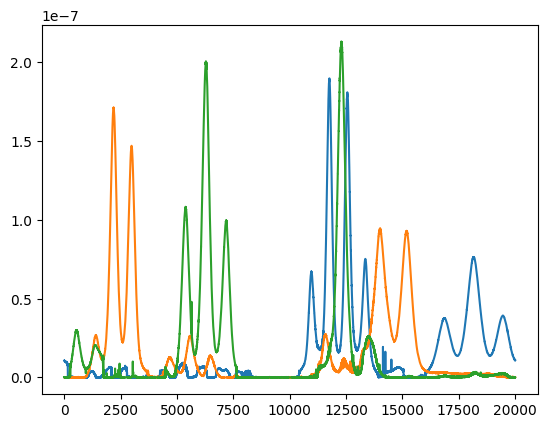

In [3]:

nmf = ShiftNMF(X_ART, 3, lr=0.1, alpha=1e-6, patience=1000, min_imp=0)
W_est, H_est, tau_est = nmf.fit(verbose=1, max_iter=500, tau_iter=0, Lambda=0.000)

plt.plot(H_est.T)
plt.show()


# Hardmodel

Found peaks:[10958 11760 12555 13354 16865 18159 19456]
sigma: 124.33306630155955 n:0.8437539512723836
sigma: 115.8926157069192 n:1.3410229139712655e-06
sigma: 117.14158830511825 n:0.031546381222986385
sigma: 132.90913580721457 n:0.6791399038677215
sigma: 282.5647735244126 n:0.7006298489785581
sigma: 276.2388186801038 n:3.8736943012788806e-07
sigma: 302.21866606777894 n:0.282787129949126
Lorentzian %:s: 0.012383963142132255
tensor([1.0000e+00, 4.8365e-09, 1.5109e-18, 1.0000e+00, 9.0830e-08, 2.9466e-09,
        1.3097e-14], grad_fn=<SigmoidBackward0>)
Sigma:
Parameter containing:
tensor([132.5575, 123.1487, 124.2137, 134.9753, 348.2187, 283.1619, 344.8160],
       requires_grad=True)
hypothesises:
{(0, 1, 4, 5), (0, 1, 6), (0, 5), (1, 2, 4, 6), (0, 1, 2, 4, 5), (0, 2, 4, 6), (3, 4, 5, 6), (2, 4, 5), (0, 2, 4), (0, 1, 5, 6), (3, 6), (0, 3, 5), (2, 3, 4, 5, 6), (0, 1, 4, 5, 6), (2, 4), (0, 2, 6), (0, 2, 3, 4, 6), (0, 1, 2, 3), (1, 2, 3, 5, 6), (1, 3, 5, 6), (6,), (0, 1, 3, 4, 6), (0, 1, 2

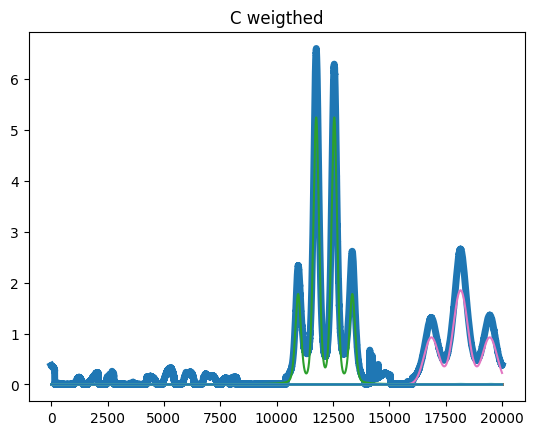

Found peaks:[ 1397  2186  2985  4681  5581  6463 11581 12350 12357 12386 12413 12433
 14012 15187]
sigma: 143.95926077481784 n:0.999999497983419
sigma: 138.630642557191 n:1.102582278207335e-06
sigma: 148.12815143923947 n:0.021839565299029317
sigma: 153.76906881880768 n:0.6909394876484051
sigma: 165.0170013277241 n:0.6159046733022502
sigma: 147.97913297736523 n:0.7071125520901121
sigma: 154.87300270825858 n:0.8353423354174834
sigma: 1119.4102383246038 n:0.9999999999999998
sigma: 37.312476964098195 n:0.9999986099336344
sigma: 1183.9246599130252 n:0.9999999687988402
sigma: 6.613173007965088 n:0.01798620996209156
sigma: 89.91209710497859 n:0.5754493874025212
sigma: 259.63715136561575 n:1.8765152364575244e-06
sigma: 237.18744370198934 n:0.015933063129747356
Lorentzian %:s: 0.009513068942235648
tensor([1.0000e+00, 2.9230e-10, 1.9102e-19, 1.0000e+00, 9.9999e-01, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.7986e-02, 1.0000e+00,
        1.7258e-10, 2.5936e-19], grad_fn

KeyboardInterrupt: 

In [5]:
for i in range(len(H_est)):
    means, sigmas, n = single_fit(H_est[i])
    #diff_matrix = calc_difference_matrix(sigmas)
    diff_matrix = calc_difference_matrix(np.ones((len(sigmas))))
    hypothesis = peak_hypothesis(diff_matrix, cutoff=10/100)
    hardmodel = Hard_Model(H_est[i], hypothesis, means, sigmas, n, lr=10, alpha = 1e-3, factor=1, patience=1, min_imp=0.01)
    W, C = hardmodel.fit(verbose=True, alpha=0.2)
    print("W:")
    print(W)
    ## TODO change this to be the true underlying components from H_ART not the shift found components, they need to be scaled accordingly.
    plt.plot(H_est[i]/np.std(H_est[i]), linewidth=5)

    for i, vec in enumerate(C):
        plt.plot(vec*W[:,i])
    plt.title("C weigthed")
    plt.show()